In [249]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import andreap
from scipy.interpolate import interp1d

import importlib.util
import sys

In [250]:
test_index = 650
validation_set = False
# skips comparison with Andrea's code
fast = True

In [251]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../nuCOMET/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_training_data", "../../nuCOMET/generate_training_data.py")
gtd = importlib.util.module_from_spec(spec)
sys.modules["generate_training_data"] = gtd
spec.loader.exec_module(gtd)

In [252]:
hc = np.load("hc_backup_i699_unlabeled.npy",
    allow_pickle=True)
samples = np.load("samples_backup_i699_unlabeled.npy",
    allow_pickle=True)

if False:
    hc = np.load("hc_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)
    samples = np.load("samples_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)

if validation_set:
    hc = np.load("hc_backup_i4999_massive_test_revised.npy",
        allow_pickle=True)
    samples = np.load("samples_backup_i4999_massive_test_revised.npy",
        allow_pickle=True)
    
standard_k = np.load("standard_k.npy", allow_pickle=True)

In [253]:
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [254]:
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [255]:
full_cosm = gtd.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [256]:
mnu = full_cosm['mnu']

In [257]:
if not fast:
    Pk_lo_h = andreap.get_PK(ombh2, omch2, ns, mnu, 10, As)
    Pk_hi_h = andreap.get_PK(ombh2, omch2, ns, mnu, 67, As)
    Pk_target_h = andreap.get_PK(ombh2, omch2, ns, mnu, 57, As)

In [258]:
if not fast:
    z = np.linspace(0., 5., 500)
    sig12 = np.zeros(500)
    for i in range(500):
        sig12[i] = andreap.get_s12(Pk_hi_h['mzero'], z[i])

    sig12[0]
    
    sig12_interpolator = interp1d(sig12, z, kind='cubic')

In [259]:
sigma12

0.6434399699829212

In [260]:
g_pspec, g_sigma12, g_z = gtd.psz(full_cosm, standard_k)
print("This is our approximation", g_sigma12)

This is our approximation 0.6434399387725378


In [261]:
import copy as cp
tilde_cosm = cp.deepcopy(full_cosm)
tilde_cosm['omch2'] += tilde_cosm['omnuh2']
tilde_cosm = ci.specify_neutrino_mass(tilde_cosm, 0, 0)
gtd.print_cosmology(tilde_cosm)
print()
gtd.print_cosmology(full_cosm)

ombh2 0.021181455000000002
omch2 0.11109400000000001
n_s 0.9448850000000001
A_s 2.2109630430252595e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.6434399699829212
omnuh2 0
mnu 0.0

ombh2 0.021181455000000002
omch2 0.107855
n_s 0.9448850000000001
A_s 2.2109630430252595e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.6434399699829212
omnuh2 0.003239
mnu 0.3012376884089687


In [262]:
kci_t, zci_t, pci_t, sci_t = ci.kzps(tilde_cosm, redshifts=[g_z], k_points=300)
kci, zci, pci, sci = ci.kzps(full_cosm, redshifts=[g_z], k_points=300)

In [263]:
sci

array([0.58224963])

In [264]:
g_pspec_t, g_sigma12_t, g_z_t = gtd.psz(tilde_cosm, standard_k)
print("This is our approximation", g_sigma12_t)

This is our approximation 0.6434399387725378


In [265]:
andreap.get_s12(Pk_hi_h['mzero'], 0)

1.0669492664260227

In [266]:
# I cannot figure out how to get AndreaP's function to work
#andreap.get_s12_fixedz(Pk_hi_h['mzero'])

In [267]:
tilde_cosm

Name           Columbus_0
ombh2            0.021181
omch2            0.111094
n_s              0.944885
A_s                   0.0
OmB                  0.05
OmC              0.268584
OmM              0.318584
OmK                   0.0
OmL              0.681416
h                    0.67
w0                   -1.0
wa                   0.00
EOmDE                   -
z(4)                  2.0
z(3)                  1.0
z(2)                 0.57
z(1)                  0.3
z(0)                  0.0
Lbox               1000.0
sigma8            0.82755
sigma12           0.64344
omnuh2                  0
mnu                   0.0
nnu_massive             0
Name: 0, dtype: object

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

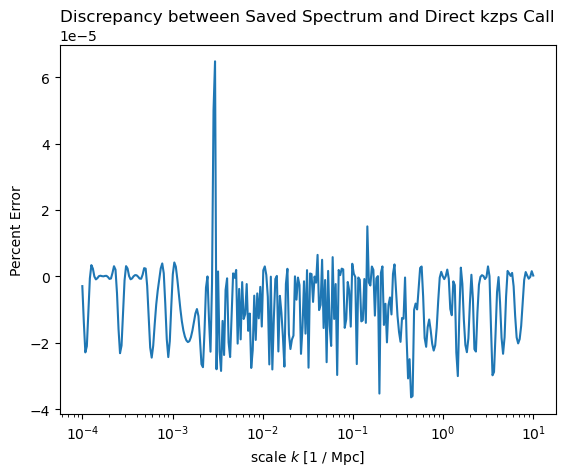

In [268]:
plt.plot(standard_k, (pci - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and Direct kzps Call")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

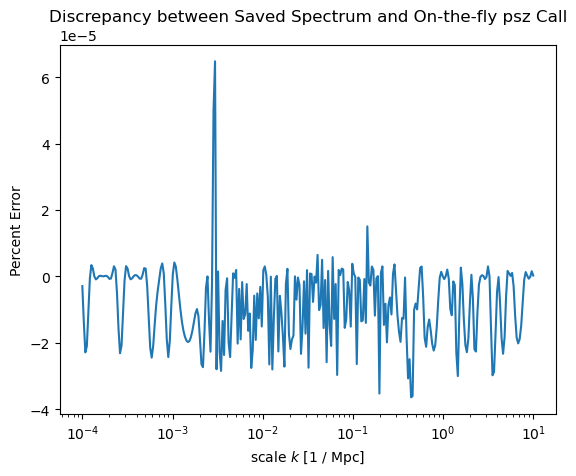

In [269]:
plt.plot(standard_k, (g_pspec - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and On-the-fly psz Call")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

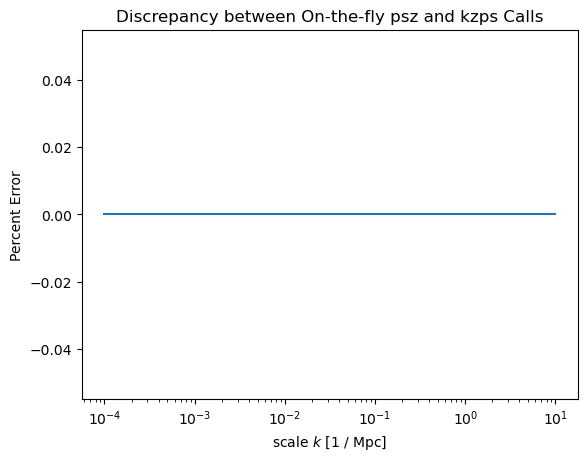

In [270]:
plt.plot(standard_k, (pci - g_pspec) / pci * 100)
plt.xscale('log')
plt.title("Discrepancy between On-the-fly psz and kzps Calls")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

This most recent plot is weak enough that we're happy. But why do we see differences in the previous plots? Is this a reproduceable discrepancy?

In [271]:
resample, bestz = gtd.fill_hypercube(hc, standard_k, massive_neutrinos=True,
    cell_range=range(1))
resample = resample[0]

We had to move h to 0.57
0 complete


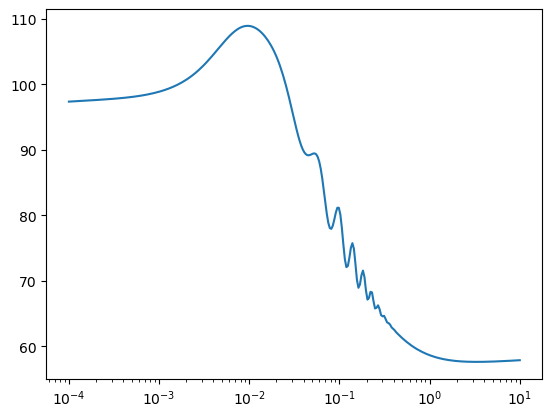

In [272]:
plt.plot(standard_k,
    (resample - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')